# Machine Learning: Clustering - DBSCAN

## 1. Introduction

Most of the traditional clustering techniques, such as k-means, hierarchical and fuzzy clustering, can be used to group data without supervision. However, when applied to tasks with arbitrary shape clusters, or clusters within cluster, the traditional techniques might be unable to achieve good results. That is, elements in the same cluster might not share enough similarity or the performance may be poor.

__Density-based spatial clustering of applications with noise (DBSCAN)__ is a data clustering algorithm proposed by Martin Ester, Hans-Peter Kriegel, Jörg Sander and Xiaowei Xu in 1996. It is a density-based clustering non-parametric algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). DBSCAN is one of the most common clustering algorithms and also most cited in scientific literature.
https://en.wikipedia.org/wiki/DBSCAN

__Understanding the DBSCAN Algorithm__

Consider a set of points in some space to be clustered. Let $\epsilon$ be a parameter specifying the radius of a neighborhood with respect to some point. For the purpose of DBSCAN clustering, the points are classified as core points, (density-)reachable points and outliers, as follows:

- A point $p$ is a core point if at least minPts points are within distance $\epsilon$ of it (including $p$).
- A point $q$ is directly reachable from $p$ if point $q$ is within distance $\epsilon$ from core point $p$. Points are only said to be directly reachable from core points.
- A point $q$ is reachable from $p$ if there is a path $p_{1}, ..., p_{n}$ with $p_{1} = p$ and $p_{n} = q$, where each $p_{i+1}$ is directly reachable from $p_{i}$. 
- Note that this implies that the initial point and all points on the path must be core points, with the possible exception of $q$.
- All points not reachable from any other point are outliers or noise points.

Now if $p$ is a core point, then it forms a cluster together with all points (core or non-core) that are reachable from it. Each cluster contains at least one core point; non-core points can be part of a cluster, but they form its "edge", since they cannot be used to reach more points. 

In this notebook, the main focus will be manipulating the data and properties of DBSCAN and observing the resulting clustering. In Section 5., data on Canadian weather station is used to show DBSCAN on real-world data. DBSCAN from Scikit-Learn is used here:
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [2]:
# import necessary libraries
import numpy as np
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics

import matplotlib.pyplot as plt 
%matplotlib inline

## 2. Data Generation for Example
The function below will generate the data points and requires these inputs:

- centroidLocation: Coordinates of the centroids that will generate the random data.
 - example: input: [4,3], [2,-1], [-1,4]
- numSamples: The number of data points we want generated, split over the number of centroids (# of centroids defined in centroidLocation)
 - Example: 750
- clusterDeviation: The standard deviation between the clusters. The larger the number, the further the spacing.
 - Example: 0.5

In [3]:
# define a function "createDataPoints" to genetate sample
def createDataPoints(centroidLocation, numSamples, clusterDeviation):
    # Create random data and store in feature matrix X and response vector y.
    X, y = make_blobs(n_samples=numSamples, centers=centroidLocation, 
                                cluster_std=clusterDeviation)
    
    # Standardize features by removing the mean and scaling to unit variance
    X = StandardScaler().fit_transform(X)
    return X, y

In [4]:
# employ function createDataPoints to generate sample data
X, y = createDataPoints([[4,3], [2,-1], [-1,4]] , 750, 0.5)

## 3. Modelling DBSCAN

Essentially, DBSCAN requires two parameters: Epsilon and Minimum Points:  
 - __epsilon__ determine a specified radius that if includes enough number of points within, we call it dense area  
 - __min_samples__ determine the minimum number of data points we want in a neighborhood to define a cluster

In [5]:
# modelling DBSCAN
epsilon = 0.3
minimumSamples = 7
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X)
labels = db.labels_
labels[0:5]

array([0, 1, 1, 0, 2])

In [6]:
# Distinguish Outliers from Clusters
# create an array of booleans using the labels from DBSCAN
# there should be 3 clusters from our sample data
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask[0:5]

array([ True,  True,  True,  True,  True])

In [7]:
# number of clusters in labels, ignoring noise if present
# there should be 3 clusters from our sample data
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
n_clusters_

3

In [8]:
# remove repetition in labels by turning it into a set
# there should be 3 clusters and -1 for outliers
unique_labels = set(labels)
unique_labels

{-1, 0, 1, 2}

In [9]:
# print evaluation metrics
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print(n_noise_, 'out of 750 sample points as noise is extremely accurate!')
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 1
1 out of 750 sample points as noise is extremely accurate!
Homogeneity: 1.000
Completeness: 0.992
V-measure: 0.996
Adjusted Rand Index: 0.998
Adjusted Mutual Information: 0.992


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Silhouette Coefficient: 0.708


## 4. Data Visualization

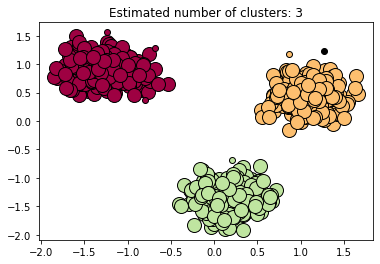

In [10]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## 5. Cananda's Weather Station and Clustering with DBSCAN
DBSCAN is especially robust for tasks like class identification or segmentation on real-world spatial data. The wonderful attribute of DBSCAN algorithm is that it can find any *arbitrary shape cluster* without getting affected by noise. For example, this following example cluster the location of weather stations in Canada.

DBSCAN can be used here, for instance, to find the group of stations which show the same weather condition. It not only finds different arbitrary shaped clusters, can find the denser part of data-centered samples by ignoring less-dense areas or noises.

Clustering Canadian Weather Stations:
1. Visualizing Weather Stations on a Map
2. Cluster Stations by Lat & Long
3. Cluster Stations by Lat, Long, Mean, Max, & Min Temp.

__About the Dataset__
- contains environment observations from all Canadian weather stations
- summarized as monthly values from 2014
- list of features below:

<html>
<head>
<style>
table {
    font-family: arial, sans-serif;
    border-collapse: collapse;
    width: 100%;
}

td, th {
    border: 1px solid #dddddd;
    text-align: left;
    padding: 8px;
}

tr:nth-child(even) {
    background-color: #dddddd;
}
</style>
</head>
<body>

<table>
  <tr>
    <th>Name in the table</th>
    <th>Meaning</th>
  </tr>
  <tr>
    <td><font color = "green"><strong>Stn_Name</font></td>
    <td><font color = "green"><strong>Station Name</font</td>
  </tr>
  <tr>
    <td><font color = "green"><strong>Lat</font></td>
    <td><font color = "green"><strong>Latitude (North+, degrees)</font></td>
  </tr>
  <tr>
    <td><font color = "green"><strong>Long</font></td>
    <td><font color = "green"><strong>Longitude (West - , degrees)</font></td>
  </tr>
  <tr>
    <td>Prov</td>
    <td>Province</td>
  </tr>
  <tr>
    <td><font color = "green"><strong>Tm</font></td>
    <td><font color = "green"><strong>Mean Temperature (°C)</font></td>
  </tr>
  <tr>
    <td>DwTm</td>
    <td>Days without Valid Mean Temperature</td>
  </tr>
  <tr>
    <td>D</td>
    <td>Mean Temperature difference from Normal (1981-2010) (°C)</td>
  </tr>
  <tr>
    <td><font color = "black">Tx</font></td>
    <td><font color = "black">Highest Monthly Maximum Temperature (°C)</font></td>
  </tr>
  <tr>
    <td>DwTx</td>
    <td>Days without Valid Maximum Temperature</td>
  </tr>
  <tr>
    <td><font color = "black">Tn</font></td>
    <td><font color = "black">Lowest Monthly Minimum Temperature (°C)</font></td>
  </tr>
  <tr>
    <td>DwTn</td>
    <td>Days without Valid Minimum Temperature</td>
  </tr>
  <tr>
    <td>S</td>
    <td>Snowfall (cm)</td>
  </tr>
  <tr>
    <td>DwS</td>
    <td>Days without Valid Snowfall</td>
  </tr>
  <tr>
    <td>S%N</td>
    <td>Percent of Normal (1981-2010) Snowfall</td>
  </tr>
  <tr>
    <td><font color = "green"><strong>P</font></td>
    <td><font color = "green"><strong>Total Precipitation (mm)</font></td>
  </tr>
  <tr>
    <td>DwP</td>
    <td>Days without Valid Precipitation</td>
  </tr>
  <tr>
    <td>P%N</td>
    <td>Percent of Normal (1981-2010) Precipitation</td>
  </tr>
  <tr>
    <td>S_G</td>
    <td>Snow on the ground at the end of the month (cm)</td>
  </tr>
  <tr>
    <td>Pd</td>
    <td>Number of days with Precipitation 1.0 mm or more</td>
  </tr>
  <tr>
    <td>BS</td>
    <td>Bright Sunshine (hours)</td>
  </tr>
  <tr>
    <td>DwBS</td>
    <td>Days without Valid Bright Sunshine</td>
  </tr>
  <tr>
    <td>BS%</td>
    <td>Percent of Normal (1981-2010) Bright Sunshine</td>
  </tr>
  <tr>
    <td>HDD</td>
    <td>Degree Days below 18 °C</td>
  </tr>
  <tr>
    <td>CDD</td>
    <td>Degree Days above 18 °C</td>
  </tr>
  <tr>
    <td>Stn_No</td>
    <td>Climate station identifier (first 3 digits indicate   drainage basin, last 4 characters are for sorting alphabetically).</td>
  </tr>
  <tr>
    <td>NA</td>
    <td>Not Available</td>
  </tr>


</table>

</body>
</html>

In [11]:
# download the dataset from IBM storage
!wget -O weather-stations20140101-20141231.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/weather-stations20140101-20141231.csv
print('Dataset Download Finished.')

Dataset Download Finished.


In [12]:
# read the dataset into a Pandas DataFrame
import pandas as pd
import numpy as np

filename='weather-stations20140101-20141231.csv'

df = pd.read_csv(filename)
df.head()

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DISCOVERY ISLAND,48.425,-123.226,BC,NaN,NaN,NaN,12.5,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012475
4,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573


In [13]:
# data cleaning: remove rows all without value in the Tm colums
df = df[pd.notnull(df["Tm"])]
df = df.reset_index(drop=True)
df["Tm"].isna().sum()

0

### 5.1 Visualizing Weather Stations on a Map
This visualization of weather stations on a map (using basemap package) is to get an overview of their locations. The matplotlib basemap toolkit is a library for plotting 2D data on maps in Python.

In [ ]:
# install package for maps
# !conda install -c conda-forge  basemap==1.2.1 matplotlib==3.1 -y

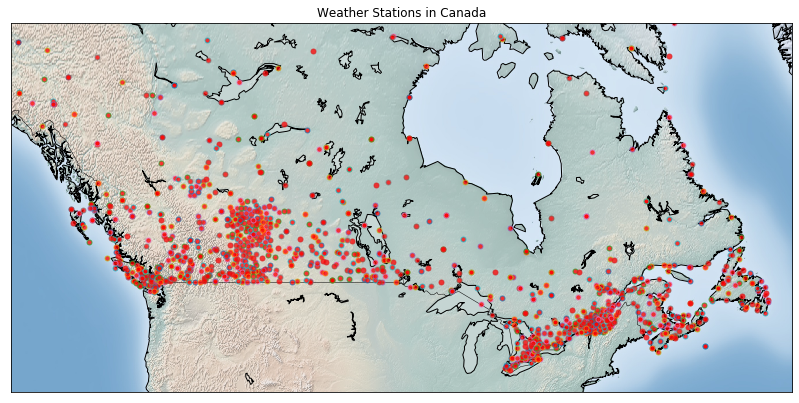

In [14]:
# Mapping out Canada's Weather Stations
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

llon=-140
ulon=-50
llat=40
ulat=65

df = df[(df['Long'] > llon) & (df['Long'] < ulon) & (df['Lat'] > llat) &(df['Lat'] < ulat)]

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
# my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on stations        

xs,ys = my_map(np.asarray(df.Long), np.asarray(df.Lat))
df['xm']= xs.tolist()
df['ym'] =ys.tolist()

#Visualization1
for index,row in df.iterrows():
#   x,y = my_map(row.Long, row.Lat)
   my_map.plot(row.xm, row.ym, markerfacecolor =([1,0,0]),  marker='o', markersize= 5, alpha = 0.75)

plt.title("Weather Stations in Canada")
plt.show()

### 5.2 Cluster Stations by Lat & Long
Weather Stations can be clustered with DBSCAN by their geographic proximity in terms of latitude and longitude. This is to demonstrate how the DBSCAN algorithm works on spatial data.

In [15]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = df[['xm','ym']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.15, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

# Number of sample in each clusters
df["Clus_Db"].value_counts()

 0    511
 3    360
-1    215
 4     42
 1     38
 2     23
Name: Clus_Db, dtype: int64

Cluster 0, Avg Temp: -5.538747553816046
Cluster 1, Avg Temp: 1.9526315789473685
Cluster 2, Avg Temp: -9.195652173913045
Cluster 3, Avg Temp: -15.300833333333333
Cluster 4, Avg Temp: -7.769047619047619


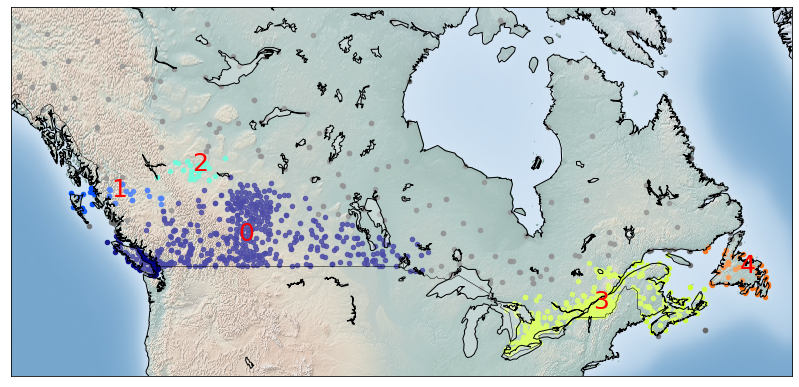

In [16]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))


#Visualization2
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = df[df.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        print ("Cluster "+str(clust_number)+', Avg Temp: '+ str(np.mean(clust_set.Tm)))

### 5.3 Cluster Stations by Lat, Long, Mean, Max, & Min Temp
The true strength of DBSCAN lies in its abilities to find clusters in high-dimension datasets. Canada' weather stations are clustered here by their latitude, longitude, mean, maximum, and minimum temperature. This (and more variables) can be used to define the climatic zones of Canada based on data.

In [17]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = df[['xm','ym','Tx','Tm','Tn']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# number of samples in each clusters
df["Clus_Db"].value_counts()

-1    428
 5    266
 3    215
 0    151
 4     51
 1     20
 2     17
 7     15
 6     14
 8     12
Name: Clus_Db, dtype: int64

Cluster 0, Avg Temp: 6.221192052980132
Cluster 1, Avg Temp: 6.790000000000001
Cluster 2, Avg Temp: -0.49411764705882344
Cluster 3, Avg Temp: -13.87720930232558
Cluster 4, Avg Temp: -4.186274509803922
Cluster 5, Avg Temp: -16.301503759398496
Cluster 6, Avg Temp: -13.599999999999998
Cluster 7, Avg Temp: -9.753333333333334
Cluster 8, Avg Temp: -4.258333333333334


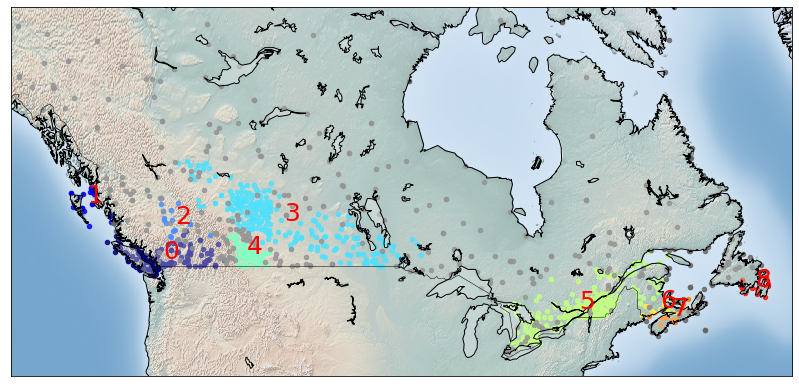

In [18]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = df[df.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        print ("Cluster "+str(clust_number)+', Avg Temp: '+ str(np.mean(clust_set.Tm)))